### 一.简介
为了让学习器越发的不同，randomforest的思路是在bagging的基础上再做一次特征的随机抽样，大致流程如下：   
![avatar](./source/10_randomforest.png)

### 二.RandomForest：分类实现

In [1]:
import os
os.chdir('../')
from ml_models import utils
from ml_models.tree import CARTClassifier
import copy
import numpy as np

"""
randomforest分类实现，封装到ml_models.ensemble
"""

class RandomForestClassifier(object):
    def __init__(self, base_estimator=None, n_estimators=10, feature_sample=0.66):
        """
        :param base_estimator: 基学习器，允许异质；异质的情况下使用列表传入比如[estimator1,estimator2,...,estimator10],这时n_estimators会失效；
                                同质的情况，单个estimator会被copy成n_estimators份
        :param n_estimators: 基学习器迭代数量
        :param feature_sample:特征抽样率
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        if self.base_estimator is None:
            # 默认使用决策树
            self.base_estimator = CARTClassifier()
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)
        self.feature_sample = feature_sample
        # 记录每个基学习器选择的特征
        self.feature_indices = []

    def fit(self, x, y):
        # TODO:并行优化
        n_sample, n_feature = x.shape
        for estimator in self.base_estimator:
            # 重采样训练集
            indices = np.random.choice(n_sample, n_sample, replace=True)
            x_bootstrap = x[indices]
            y_bootstrap = y[indices]
            # 对特征抽样
            feature_indices = np.random.choice(n_feature, int(n_feature * self.feature_sample), replace=False)
            self.feature_indices.append(feature_indices)
            x_bootstrap = x_bootstrap[:, feature_indices]
            estimator.fit(x_bootstrap, y_bootstrap)

    def predict_proba(self, x):
        # TODO:并行优化
        probas = []
        for index, estimator in enumerate(self.base_estimator):
            probas.append(estimator.predict_proba(x[:, self.feature_indices[index]]))
        return np.mean(probas, axis=0)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [2]:
#造伪数据
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

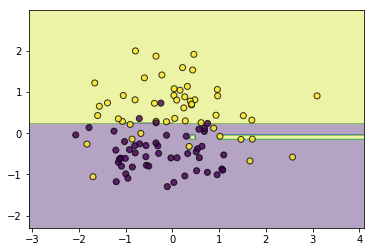

In [3]:
#同质
classifier = RandomForestClassifier(feature_sample=0.6)
classifier.fit(data, target)
utils.plot_decision_function(data, target, classifier)

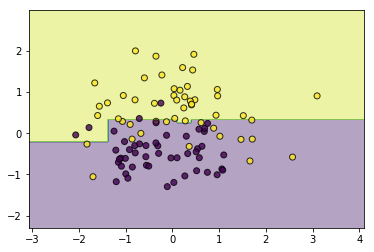

In [4]:
#异质
from ml_models.linear_model import LogisticRegression
from ml_models.svm import SVC
classifier = RandomForestClassifier(base_estimator=[LogisticRegression(),SVC(kernel='rbf',C=5.0),CARTClassifier(max_depth=2)],feature_sample=0.6)
classifier.fit(data, target)
utils.plot_decision_function(data, target, classifier)

### 三.代码实现：回归

In [5]:
from ml_models.tree import CARTRegressor

"""
random forest回归实现，封装到ml_models.ensemble
"""

class RandomForestRegressor(object):
    def __init__(self, base_estimator=None, n_estimators=10, feature_sample=0.66):
        """
        :param base_estimator: 基学习器，允许异质；异质的情况下使用列表传入比如[estimator1,estimator2,...,estimator10],这时n_estimators会失效；
                                同质的情况，单个estimator会被copy成n_estimators份
        :param n_estimators: 基学习器迭代数量
        :param feature_sample:特征抽样率
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        if self.base_estimator is None:
            # 默认使用决策树
            self.base_estimator = CARTRegressor()
        # 同质
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质
        else:
            self.n_estimators = len(self.base_estimator)
        self.feature_sample = feature_sample
        # 记录每个基学习器选择的特征
        self.feature_indices = []

    def fit(self, x, y):
        # TODO:并行优化
        n_sample, n_feature = x.shape
        for estimator in self.base_estimator:
            # 重采样训练集
            indices = np.random.choice(n_sample, n_sample, replace=True)
            x_bootstrap = x[indices]
            y_bootstrap = y[indices]
            # 对特征抽样
            feature_indices = np.random.choice(n_feature, int(n_feature * self.feature_sample), replace=False)
            self.feature_indices.append(feature_indices)
            x_bootstrap = x_bootstrap[:, feature_indices]
            estimator.fit(x_bootstrap, y_bootstrap)

    def predict(self, x):
        # TODO:并行优化
        preds = []
        for index, estimator in enumerate(self.base_estimator):
            preds.append(estimator.predict(x[:, self.feature_indices[index]]))

        return np.mean(preds, axis=0)

In [6]:
#构造数据
data = np.linspace(1, 10, num=100)
target1 = 3*data[:50] + np.random.random(size=50)*3#添加噪声
target2 = 3*data[50:] + np.random.random(size=50)*10#添加噪声
target=np.concatenate([target1,target2])
data = data.reshape((-1, 1))

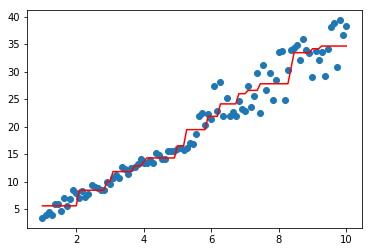

In [7]:
#同质
import matplotlib.pyplot as plt
model=RandomForestRegressor(base_estimator=CARTRegressor(),n_estimators=2,feature_sample=1)#feature就一列，没办法...
model.fit(data,target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')

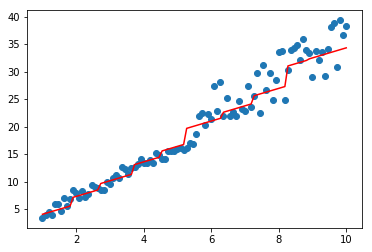

In [8]:
#异质
from ml_models.linear_model import LinearRegression
model=RandomForestRegressor(base_estimator=[LinearRegression(),CARTRegressor()],feature_sample=1)
model.fit(data,target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')